In [1]:
# Notebook for Analysis of Hexosaminidase Assay.

In [2]:
from collections import defaultdict

import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
# Set working directory for this experiment.
# Working directory should be where raw data are saved.
# Processed data will also save here.
import os

directory = "/Users/justin/Documents/itch_peptides/experimental_data/20241217_hex_assay_sandbox/"

os.chdir(directory)
print(os.getcwd())

/Users/justin/Documents/itch_peptides/experimental_data/20241217_hex_assay_sandbox


In [4]:
# Parameterization.

data_filename = "20241217_hex_assay.csv"  # enter raw data file name here.
manifest_filename = "20241217_hex_manifest.csv"  # enter sample manifest file name here.

# change this value as needed to match
# the data label for the background column.
blank = "Blank"

# enter the standard labels as a list of strings.
standard_vals = [
    "500",
    "250",
    "125",
    "0",
]

# enter the name of the experiment as a string for plot labels.
experiment_name = "Exp 11 Hexosaminidase Assay"

In [5]:
data_path = os.path.join(directory, data_filename)

if os.path.exists(data_path):
    data = pd.read_csv(data_path)
    print(f"File '{data_filename}' loaded successfully.")
else:
    print(f"Error: File '{data_filename}' not found in the directory '{directory}'.")
    print(
    """
    Please check the file path, file name, and ensure the file is present
    in the working directory.
    """
)

File '20241217_hex_assay.csv' loaded successfully.


In [10]:
# Metadata are found in rows where both column A and column B have non-empty values,
# so metadata are extracted by identifying rows with non-empty values in these columns.

metadata = data.dropna(subset=["User", "Public"])
metadata = metadata.iloc[:, :2]
metadata.to_csv(data_filename[:-4] + "_metadata.csv", index=False)
metadata

,User,Public
0,Protocol name,New FL Protocol
1,Time of export,12/17/2024 23:27:46
2,Time of last change,12/17/2024 23:25:37
3,Time of last use (end time),12/17/2024 23:27:21
4,Software version,1.2.0.0
5,Instrument name,iD3-2585
6,Serial number,2585
10,Experiment name,Experiment 1
13,Plate name,Plate 1
15,Microplate name,Standard clrbtm


In [11]:
# Sample data are laid out in a 96-well plate format,
# look for a row where columns contain values 1, 2, ..., 12.
header_row = data.apply(
    lambda row: all(1.0 <= val <= 12.0 for val in pd.to_numeric(row[2:], errors='coerce').fillna(-1)),
    axis=1
)
header_index = header_row.idxmax()

sample_data = data.iloc[header_index:].reset_index(drop=True)
sample_data = sample_data.iloc[1:, 2:].reset_index(drop=True)
sample_data.columns = range(1, sample_data.shape[1] + 1)
sample_data.to_csv(data_filename[:-4] + "_sample_data.csv", index=False)

sample_data

,1,2,3,4,5,6,7,8,9,10,11,12
0,16208002.0,17807858.0,16948784.0,12522665.0,13742980.0,12808170.0,19909278.0,7156088.0,79392744.0,36714332.0,16628961.0,1984782.0
1,15596640.0,17754340.0,16958830.0,12012972.0,12236627.0,11967005.0,18039790.0,6830822.0,73706544.0,33151446.0,15956867.0,1995358.0
2,16372320.0,17092102.0,16667860.0,12263680.0,12487558.0,12214759.0,19114838.0,6900832.0,73649640.0,32054976.0,15748900.0,2016598.0
3,673247.0,679811.0,704365.0,346434.0,345405.0,343059.0,340359.0,339812.0,340401.0,341214.0,341042.0,336003.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Data must be restructured and labeled for plotting and analysis,
# so sample manifest is used to sort and label data.

manifest_path = os.path.join(directory, manifest_filename)

if os.path.exists(manifest_path):
    manifest = pd.read_csv(manifest_filename)
    manifest = manifest.drop(columns="Manifest")
    print(f"File '{manifest_filename}' loaded successfully.")
else:
    print(
        f"Error: File '{manifest_filename}' not found in the directory '{directory}'."
    )
    print(
    """
    Please check the file path, file name, and ensure the file is present
    in the working directory.
    """
    )

manifest

File '20241217_hex_manifest.csv' loaded successfully.


,1,2,3,4,5,6,7,8,9,10,11,12
0,Cq 300 µM,Cq 100 µM,Cq 33.3 µM,bAla 100 µM,bAla 33.3 µM,bAla 11.1 µM,48/80,DMSO,500.0,250.0,125.0,0.0
1,Cq 300 µM,Cq 100 µM,Cq 33.3 µM,bAla 100 µM,bAla 33.3 µM,bAla 11.1 µM,48/80,DMSO,500.0,250.0,125.0,0.0
2,Cq 300 µM,Cq 100 µM,Cq 33.3 µM,bAla 100 µM,bAla 33.3 µM,bAla 11.1 µM,48/80,DMSO,500.0,250.0,125.0,0.0
3,Blank,Blank,Blank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Unique sample names should be extracted from the sample manifest.
# The printout of this cell can be used to confirm that this was done correctly.


def extract_column_headers(dataframe):
    """
    Extract all unique sample names from the sample manifest.

    Args:
        dataframe:
            a pandas dataframe containing the sample labels
            loaded from the sample manifest csv.

    Returns:
        columns:
            a list of unique sample names extracted
            from non-empty cells of the sample manifest.

    """
    columns = []
    for _, row in dataframe.iterrows():
        for cell in row:
            if pd.notna(cell) and cell not in columns:
                columns.append(cell)
    return columns


columns = extract_column_headers(manifest)
columns = [str(int(item)) if isinstance(item, float) else item for item in columns]
print(columns)

['Cq 300 µM', 'Cq 100 µM', 'Cq 33.3 µM', 'bAla 100 µM', 'bAla 33.3 µM', 'bAla 11.1 µM', '48/80', 'DMSO', '500', '250', '125', '0', 'Blank']


In [14]:
json_data = defaultdict(list)

for row_idx, row in sample_data.iterrows():
    for col_idx, value in enumerate(row):
        if pd.notna(value):
            key = manifest.iloc[row_idx, col_idx]

            if pd.notna(key):
                json_data[key].append(value)

labeled_data = dict(json_data)

max_length = max(len(value) for value in labeled_data.values())
labeled_data = {
    str(int(key)) if isinstance(key, float) and key.is_integer() else key: value
    + [np.nan] * (max_length - len(value))
    for key, value in labeled_data.items()
}

labeled_df = pd.DataFrame(labeled_data)
labeled_df

,Cq 300 µM,Cq 100 µM,Cq 33.3 µM,bAla 100 µM,bAla 33.3 µM,bAla 11.1 µM,48/80,DMSO,500,250,125,0,Blank
0,16208002.0,17807858.0,16948784.0,12522665.0,13742980.0,12808170.0,19909278.0,7156088.0,79392744.0,36714332.0,16628961.0,1984782.0,673247.0
1,15596640.0,17754340.0,16958830.0,12012972.0,12236627.0,11967005.0,18039790.0,6830822.0,73706544.0,33151446.0,15956867.0,1995358.0,679811.0
2,16372320.0,17092102.0,16667860.0,12263680.0,12487558.0,12214759.0,19114838.0,6900832.0,73649640.0,32054976.0,15748900.0,2016598.0,704365.0


In [15]:
# Background signal should be subtracted from all samples.
blank_mean = labeled_df[blank].mean()

labeled_df = labeled_df - blank_mean
labeled_df = labeled_df.drop(columns=blank)
labeled_df.to_csv(data_filename[:-4] + "_labeled.csv", index=False)
labeled_df

,Cq 300 µM,Cq 100 µM,Cq 33.3 µM,bAla 100 µM,bAla 33.3 µM,bAla 11.1 µM,48/80,DMSO,500,250,125,0
0,1.552219e+07,1.712205e+07,1.626298e+07,1.183686e+07,1.305717e+07,1.212236e+07,1.922347e+07,6.470280e+06,7.870694e+07,3.602852e+07,1.594315e+07,1.298974e+06
1,1.491083e+07,1.706853e+07,1.627302e+07,1.132716e+07,1.155082e+07,1.128120e+07,1.735398e+07,6.145014e+06,7.302074e+07,3.246564e+07,1.527106e+07,1.309550e+06
2,1.568651e+07,1.640629e+07,1.598205e+07,1.157787e+07,1.180175e+07,1.152895e+07,1.842903e+07,6.215024e+06,7.296383e+07,3.136917e+07,1.506309e+07,1.330790e+06


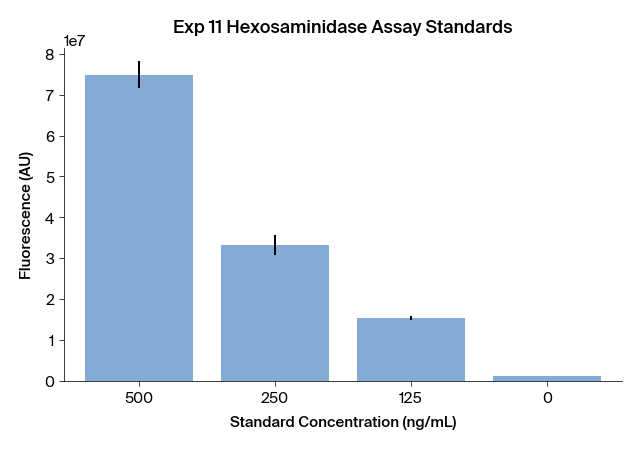

In [16]:
standards = labeled_df[standard_vals]

means = standards.mean()
std_devs = standards.std()

apc.mpl.setup()
plt.figure(figsize=(10, 6))
bars = plt.bar(means.index, means.values, yerr=std_devs.values, capsize=5, alpha=0.7)

# User can update labels and title as needed.
plt.xlabel("Standard Concentration (ng/mL)")
plt.ylabel("Fluorescence (AU)")
plt.title(experiment_name + " Standards")

plt.savefig(data_filename[:-4] + "_standards.png", transparent=False)
plt.show()

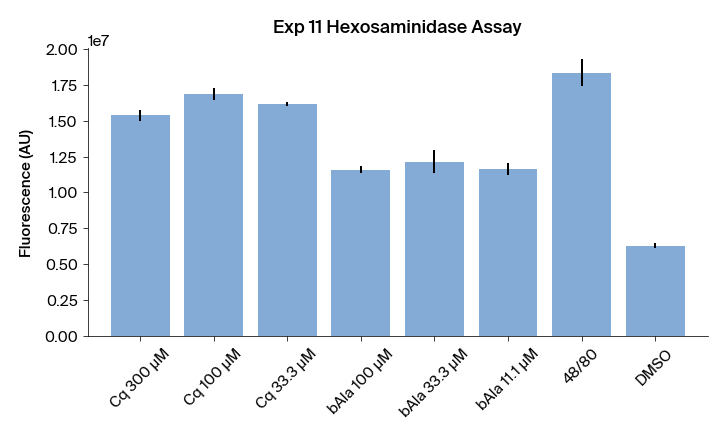

In [17]:
columns = labeled_df.columns.tolist()
sample_columns = [col for col in columns if col not in standards and col != blank]

samples = labeled_df[sample_columns]

sample_means = samples.mean()
sample_std_devs = samples.std()

plt.figure(figsize=(10, 6))
bars = plt.bar(
    sample_means.index,
    sample_means.values,
    yerr=sample_std_devs.values,
    capsize=5,
    alpha=0.7,
)

# User can update labels and title as needed.
plt.ylabel("Fluorescence (AU)")
plt.title(experiment_name)

# Optionally adjust x-axis tick labels to avoid overlapping when plotting many samples.
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability.
plt.tight_layout()

plt.savefig(data_filename[:-4] + "_samples.png", transparent=False)
plt.show()

In [18]:
# Data must be reshaped for statistical analysis.
samples_melt = samples.melt(var_name="Treatment", value_name="Concentration")
samples_melt

,Treatment,Concentration
0,Cq 300 µM,1.552219e+07
1,Cq 300 µM,1.491083e+07
2,Cq 300 µM,1.568651e+07
3,Cq 100 µM,1.712205e+07
4,Cq 100 µM,1.706853e+07
5,Cq 100 µM,1.640629e+07
6,Cq 33.3 µM,1.626298e+07
7,Cq 33.3 µM,1.627302e+07
8,Cq 33.3 µM,1.598205e+07
9,bAla 100 µM,1.183686e+07


In [19]:
# One-way ANOVA is the most appropriate statistical test for these data.
anova_result = f_oneway(*(samples[col] for col in sample_columns))
print(
    f"ANOVA result: F-value = {anova_result.statistic}, p-value = {anova_result.pvalue}"
)

ANOVA result: F-value = 168.58065639682394, p-value = 8.838238889347235e-14


In [20]:
# Tukey's HSD test is the most appropriate statistical test for post-hoc analysis.
tukey_result = pairwise_tukeyhsd(
    endog=samples_melt["Concentration"], groups=samples_melt["Treatment"], alpha=0.05
)
print(tukey_result)

tukey_df = pd.DataFrame(
    data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0]
)
tukey_df.to_csv(data_filename[:-4] + "_tukey_hsd_results.csv", index=False)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
   group1       group2       meandiff    p-adj      lower          upper      reject
------------------------------------------------------------------------------------
       48/80    Cq 100 µM  -1469868.6667 0.0502  -2940801.8713       1064.538  False
       48/80    Cq 300 µM  -2962314.6667 0.0001  -4433247.8713   -1491381.462   True
       48/80   Cq 33.3 µM  -2162810.6667 0.0021  -3633743.8713    -691877.462   True
       48/80         DMSO -12058721.3333    0.0  -13529654.538 -10587788.1287   True
       48/80  bAla 100 µM     -6754863.0    0.0  -8225796.2047  -5283929.7953   True
       48/80 bAla 11.1 µM     -6691324.0    0.0  -8162257.2047  -5220390.7953   True
       48/80 bAla 33.3 µM  -6198913.6667    0.0  -7669846.8713   -4727980.462   True
   Cq 100 µM    Cq 300 µM     -1492446.0 0.0455  -2963379.2047    -21512.7953   True
   Cq 100 µM   Cq 33.3 µM      -692942.0 0.7269  -2163875.2047   

In [21]:
import sys
loaded_modules = {name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, '__version__')}
print(loaded_modules)

{'re': '2.2.1', 'ipaddress': '1.0', 'ipykernel._version': '6.29.4', 'json': '2.0.9', 'jupyter_client._version': '8.6.2', 'platform': '1.0.8', 'zmq.sugar.version': '26.0.3', 'zmq.sugar': '26.0.3', 'zmq': '26.0.3', 'logging': '0.5.1.2', 'traitlets._version': '5.14.3', 'traitlets': '5.14.3', 'jupyter_core.version': '5.7.2', 'jupyter_core': '5.7.2', 'zlib': '1.0', '_curses': b'2.2', 'socketserver': '0.4', 'argparse': '1.1', 'dateutil._version': '2.9.0.post0', 'dateutil': '2.9.0.post0', 'six': '1.16.0', '_decimal': '1.70', 'decimal': '1.70', 'platformdirs.version': '4.2.2', 'platformdirs': '4.2.2', '_csv': '1.0', 'csv': '1.0', 'jupyter_client': '8.6.2', 'ipykernel': '6.29.4', 'IPython.core.release': '8.26.0', 'executing.version': '2.0.1', 'executing': '2.0.1', 'pure_eval.version': '0.2.2', 'pure_eval': '0.2.2', 'stack_data.version': '0.6.3', 'stack_data': '0.6.3', 'pygments': '2.18.0', 'decorator': '5.1.1', 'wcwidth': '0.2.13', 'prompt_toolkit': '3.0.47', 'parso': '0.8.4', 'jedi': '0.19.1',

/var/folders/f0/d5_1_5d11vl9ywq_z1j0nnk40000gn/T/ipykernel_32664/676464476.py:2: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.__version__.
  loaded_modules = {name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, '__version__')}
